In [16]:
import numpy as np
import matplotlib.pyplot as plt
import gillespy2
from scipy.optimize import minimize

In [17]:
#Repressor System
def CLE(beta1, k1, n1, alpha, dt):
    x = [x0]
    for i in range(len(t) - 1):
        dxi = np.random.normal(0, 1, 3) 
        x_curr = x[-1]
        
        

        F = (beta1 * (pow(k1, n1) )/ (pow(k1, n1) + pow(x_curr, n1)) -
            alpha * x_curr)
        
        G = (
            np.sqrt(beta1 * (pow(k1, n1) / (pow(k1, n1) + pow(x_curr, n1)))) * dxi[0] +
            
            np.sqrt(alpha * x_curr) * dxi[1])
        
        x_next = x_curr + dt * F + np.sqrt(dt) * G

        x = np.hstack([x, x_next])
    return x

In [18]:
beta1=10
k1=50
n1=1
alpha=0.02
t = np.linspace(0,100000,10000)
dt = t[1] - t[0]
x0=200
x_cle = CLE( beta1,k1, n1, alpha, dt)
x_cle_trimmed = x_cle[1000:]



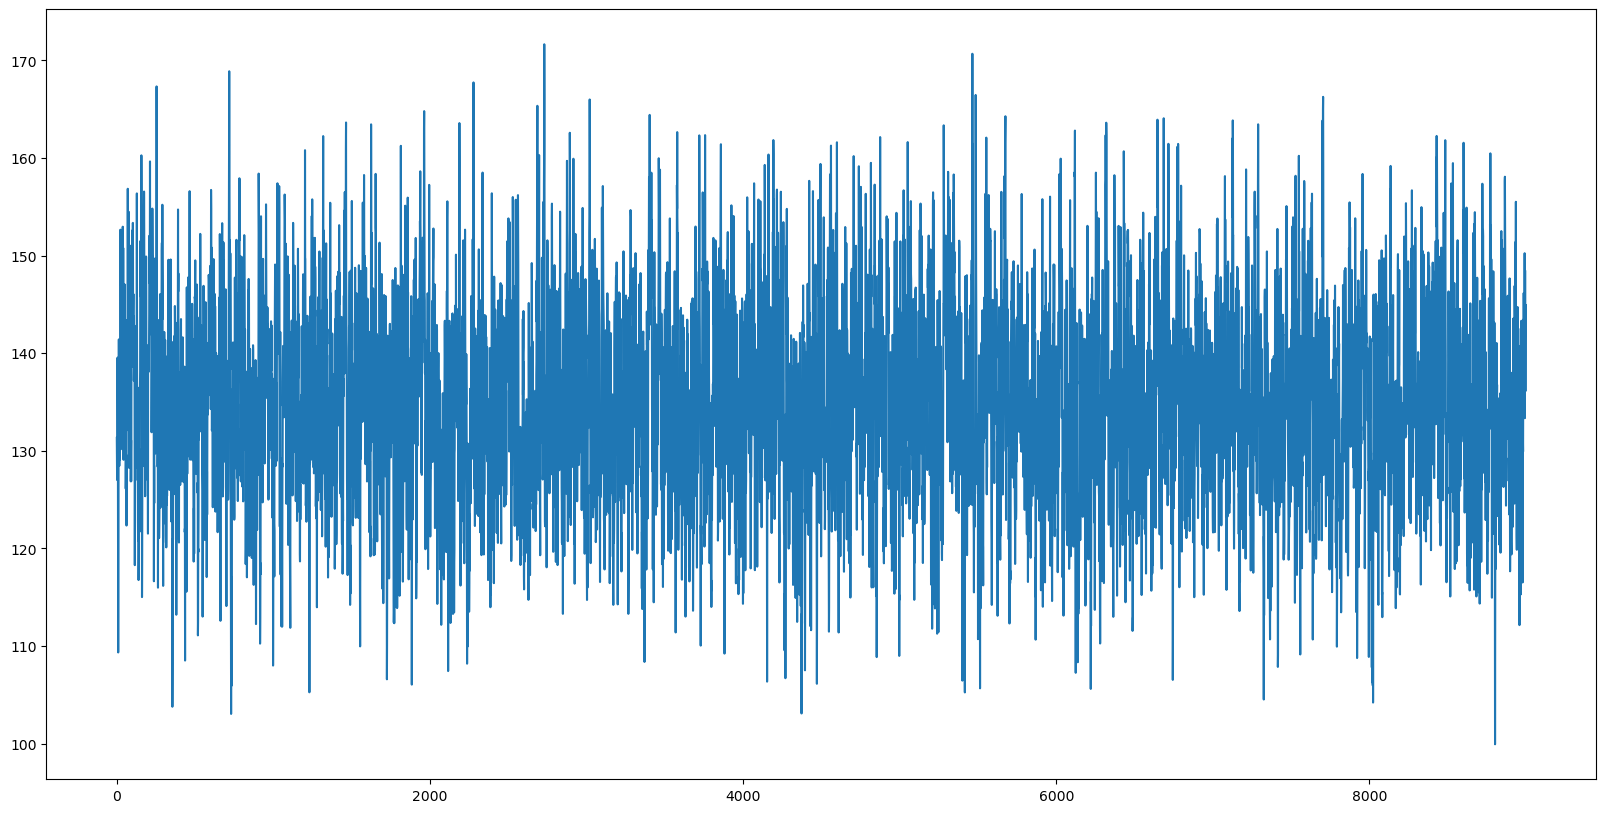

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(x_cle_trimmed, label='cle')


In [20]:
print(x_cle_trimmed)


[131.32242362 128.35358249 127.00991955 ... 140.29514725 144.95397505
 144.05133243]


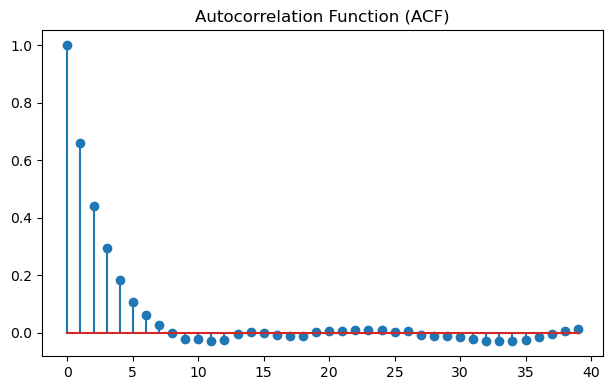

In [21]:
import statsmodels.api as sm
# Calculate the autocorrelation function (ACF)
acf = sm.tsa.acf(x_cle_trimmed, fft=False)


# Calculate the partial autocorrelation function (PACF)
pacf = sm.tsa.pacf(x_cle_trimmed)

# Plot the ACF
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.stem(acf)
plt.title('Autocorrelation Function (ACF)')



plt.tight_layout()
plt.show()

In [22]:
print(acf)

[ 1.          0.66154171  0.44094645  0.29362983  0.18403519  0.10860541
  0.06300765  0.02567985 -0.00051862 -0.02035504 -0.02284078 -0.02786533
 -0.02428718 -0.00393399  0.00434587  0.00024839 -0.00655553 -0.01215864
 -0.00986769  0.00256597  0.0068171   0.00801747  0.00893862  0.01021385
  0.00877934  0.00385009  0.00552963 -0.00618596 -0.00999936 -0.01039653
 -0.01424905 -0.01992393 -0.0297295  -0.02914714 -0.02983606 -0.02370539
 -0.01515448 -0.00391398  0.00522979  0.01376904]


In [23]:
threshold = 0.2
autocorrelation_time = next(i for i, acf_value in enumerate(acf) if acf_value < threshold)

print(f"Autocorrelation Time: {autocorrelation_time}")

Autocorrelation Time: 4


In [67]:
np.mean(x_cle_trimmed)

135.74851077197349

In [68]:
np.std(x_cle_trimmed)

9.73229902008993

In [69]:
def f_rep(x_cle_trimmed, k1, n1, beta1):
    return beta1 * (pow(k1, n1) / (pow(k1, n1) + pow(x_cle_trimmed, n1)))

def f_act(x_cle_trimmed, n2, k2, beta2):
    return beta2 * (pow(x_cle_trimmed, n2) / (pow(k2, n2) + pow(x_cle_trimmed, n2)))

def f_deg(x, alpha):
    return alpha * x_cle_trimmed

In [70]:


def fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha):
    try:
        fix_rep_pt = (-alpha * k1 + np.sqrt((k1**2) * (alpha**2) + 4 * alpha * k1*beta1)) / (2 * alpha)
        return fix_rep_pt
    except ValueError as e:
        print(f"Error: {e}")
        return None

fix_rep_pt = fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha)
if fix_rep_pt is not None:
    print('fix_rep:', fix_rep_pt)


fix_rep: 135.0781059358212


In [71]:
A=(beta1 * n1 * pow(k1, n1) * pow(fix_rep_pt, n1 - 1))/((pow(fix_rep_pt, n1) + pow(k1, n1))**2) +alpha
B=(beta1 * pow(k1, n1))/(pow(fix_rep_pt, n1) + pow(k1, n1))+alpha*fix_rep_pt
   

In [72]:
np.sqrt(B/(2*A))

8.836678162313202

In [73]:
def fixed_point_act(x_cle_trimmed, beta2, k2, n2, alpha):
    try:
        fix_act_pt = (beta2 - alpha * k2) / alpha
        return fix_act_pt
    except ValueError as e:
        print(f"Error: {e}")
        return None


In [74]:
def A_r(fix_act_pt, beta2, n2, K2, alpha):
    denominator = pow(fix_act_pt, n2) + pow(K2, n2)
    numerator = -beta2 * n2 * pow(K2, n2) * pow(fix_act_pt, n2 - 1)
    result = (numerator / pow(denominator, 2)) + alpha
    return result

def B_r(fix_act_pt, beta2, n2, K2, alpha):
    denominator = pow(fix_act_pt, n2) + pow(K2, n2)
    numerator = beta2 * pow(fix_act_pt, n2)
    result = (numerator / denominator) + alpha * fix_act_pt
    return result


In [75]:
def cost_function(params, fix_rep_pt, x_cle_trimmed, k1, beta1, alpha, n2):
    beta2, K2 = params
    
    fix_act_pt = fixed_point_act(x_cle_trimmed, beta2, K2, n2, alpha)
    
    A = (beta1 * n1 * pow(k1, n1) * pow(fix_rep_pt, n1 - 1)) / ((pow(fix_rep_pt, n1) + pow(k1, n1))**2) + alpha
    B = (beta1 * pow(k1, n1)) / (pow(fix_rep_pt, n1) + pow(k1, n1)) + alpha * fix_rep_pt
   
    A_r_val = A_r(fix_act_pt, beta2, n2, K2, alpha)
    B_r_val = B_r(fix_act_pt, beta2, n2, K2, alpha)
    
    expression_diff = np.abs(B / (2 * A) - B_r_val / (2 * A_r_val))**2 + 13* np.abs(fix_act_pt - fix_rep_pt)**2
    
    return np.sum(expression_diff)


In [76]:
# Set up the bounds
bounds_definition = [(0, None), (0, None)] 
n2 = 1

initial_guess = [0.1, 1]

result = minimize(cost_function, initial_guess, args=(fix_rep_pt, x_cle_trimmed, k1, beta1, alpha, n1),
                  method='trust-constr', tol=1e-6, options={'maxiter': 1000},
                  bounds=bounds_definition)

optimized_params = result.x

print("Optimized parameters (beta2, K2):", optimized_params)



Optimized parameters (beta2, K2): [2.62014607 0.0000003 ]


In [77]:
optimized_params = [2.62014607 ,0.0000003 ]


fix_act_pt_optimized = fixed_point_act(x_cle_trimmed, optimized_params[0], optimized_params[1], n2, alpha)
print("Fixed point value at optimized parameters:", fix_act_pt_optimized)

Fixed point value at optimized parameters: 131.0073032


In [78]:
A_r_val = A_r(fix_act_pt_optimized ,optimized_params[0], n2, optimized_params[1], alpha)
print(A_r_val)
B_r_val = B_r(fix_act_pt_optimized ,optimized_params[0], n2, optimized_params[1], alpha)
print(B_r_val)
print(B_r_val/(2*A_r_val))

0.019999999954201028
5.240292128
131.0073035


In [79]:
print(np.sqrt(B_r_val/(2*A_r_val)))#repressor variance 

11.445842192691632
